In [1]:
import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline
import numpy as np
import cv2
import torch
from data.xray import XRayDataset

In [2]:
dataset = XRayDataset('/media/data/jinnan2/jinnan2_round2_train_20190401',
                        '/media/data/jinnan2/jinnan2_round2_train_20190401/train_restriction.json',
                      mixup_normal_images=True
                     )
print(dataset.classnames)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
['background', '铁壳打火机', '黑钉打火机', '刀具', '电源和电池', '剪刀']


In [3]:
len(dataset)

2021

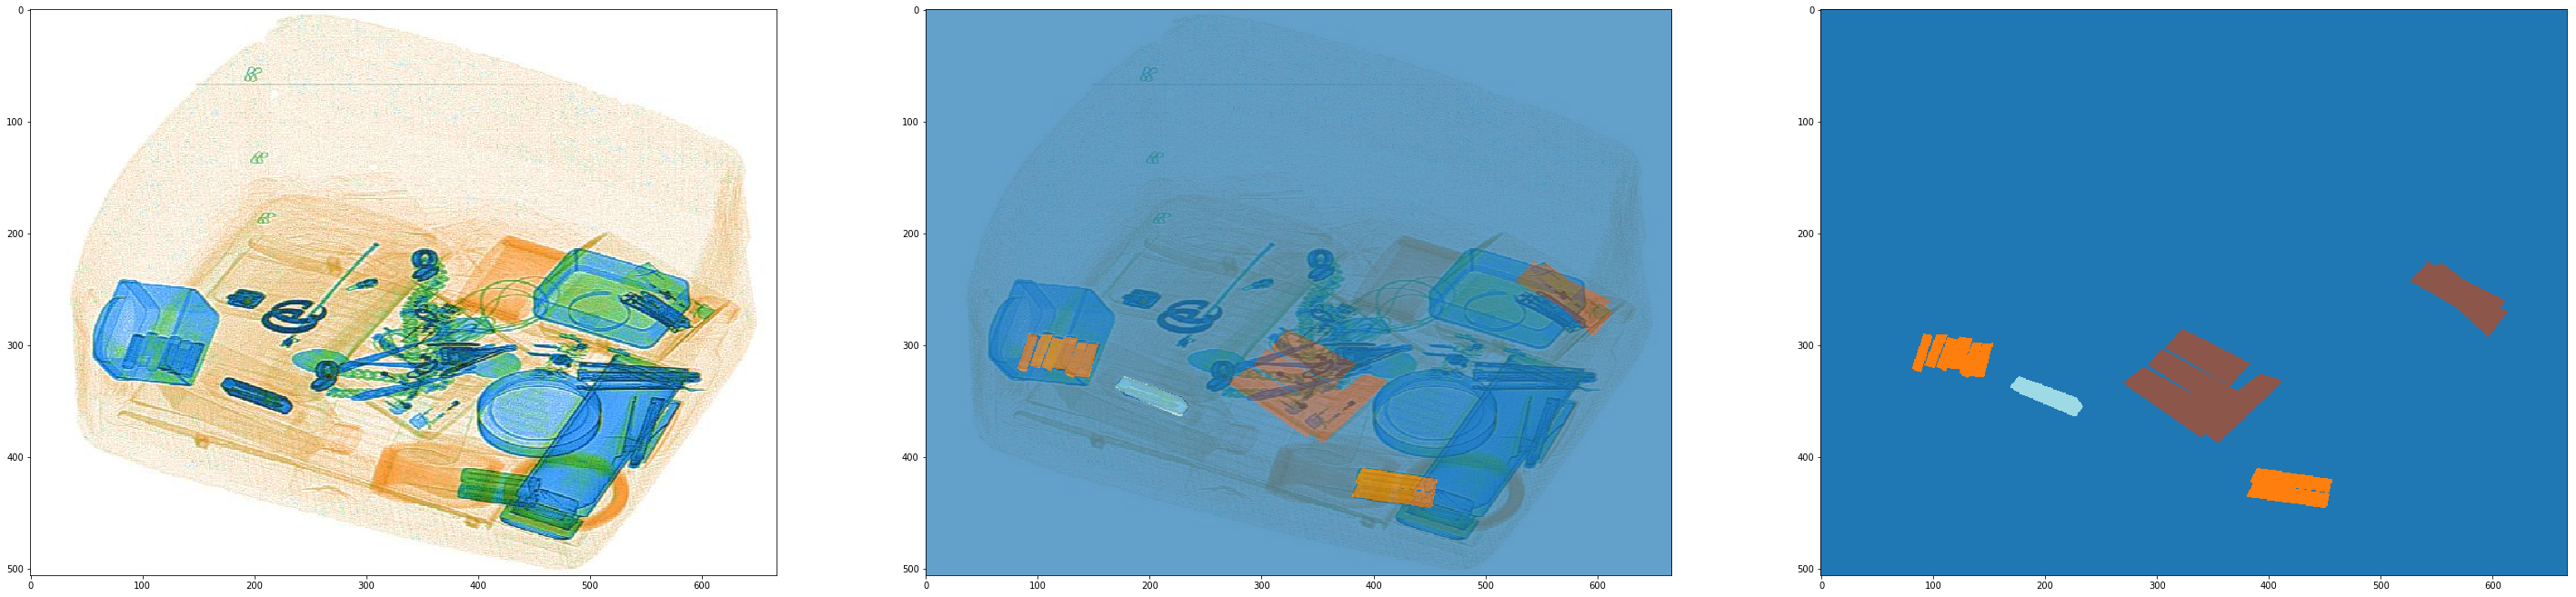

In [4]:
sample = dataset[0]

def show_sample_and_mask(sample):
    plt.figure(figsize=(50, 20))
    plt.subplot(1, 3, 1)
    if 'image' in sample and not torch.is_tensor(sample['image']):
        plt.imshow(sample['image'])
    masks = sample['masks']
    
    #print(sample)
    cmap = 'tab20'
    plt.subplot(1, 3, 3)
    if 'edges' in sample:
        plt.imshow(sample['edges'], cmap=cmap)
    else:
        plt.imshow(masks, cmap=cmap)
    plt.subplot(1, 3, 2)
    if 'image' in sample and not torch.is_tensor(sample['image']):
        plt.imshow(sample['image'])
    plt.imshow(masks,alpha=0.7, cmap=cmap)
    plt.show()
show_sample_and_mask(sample)

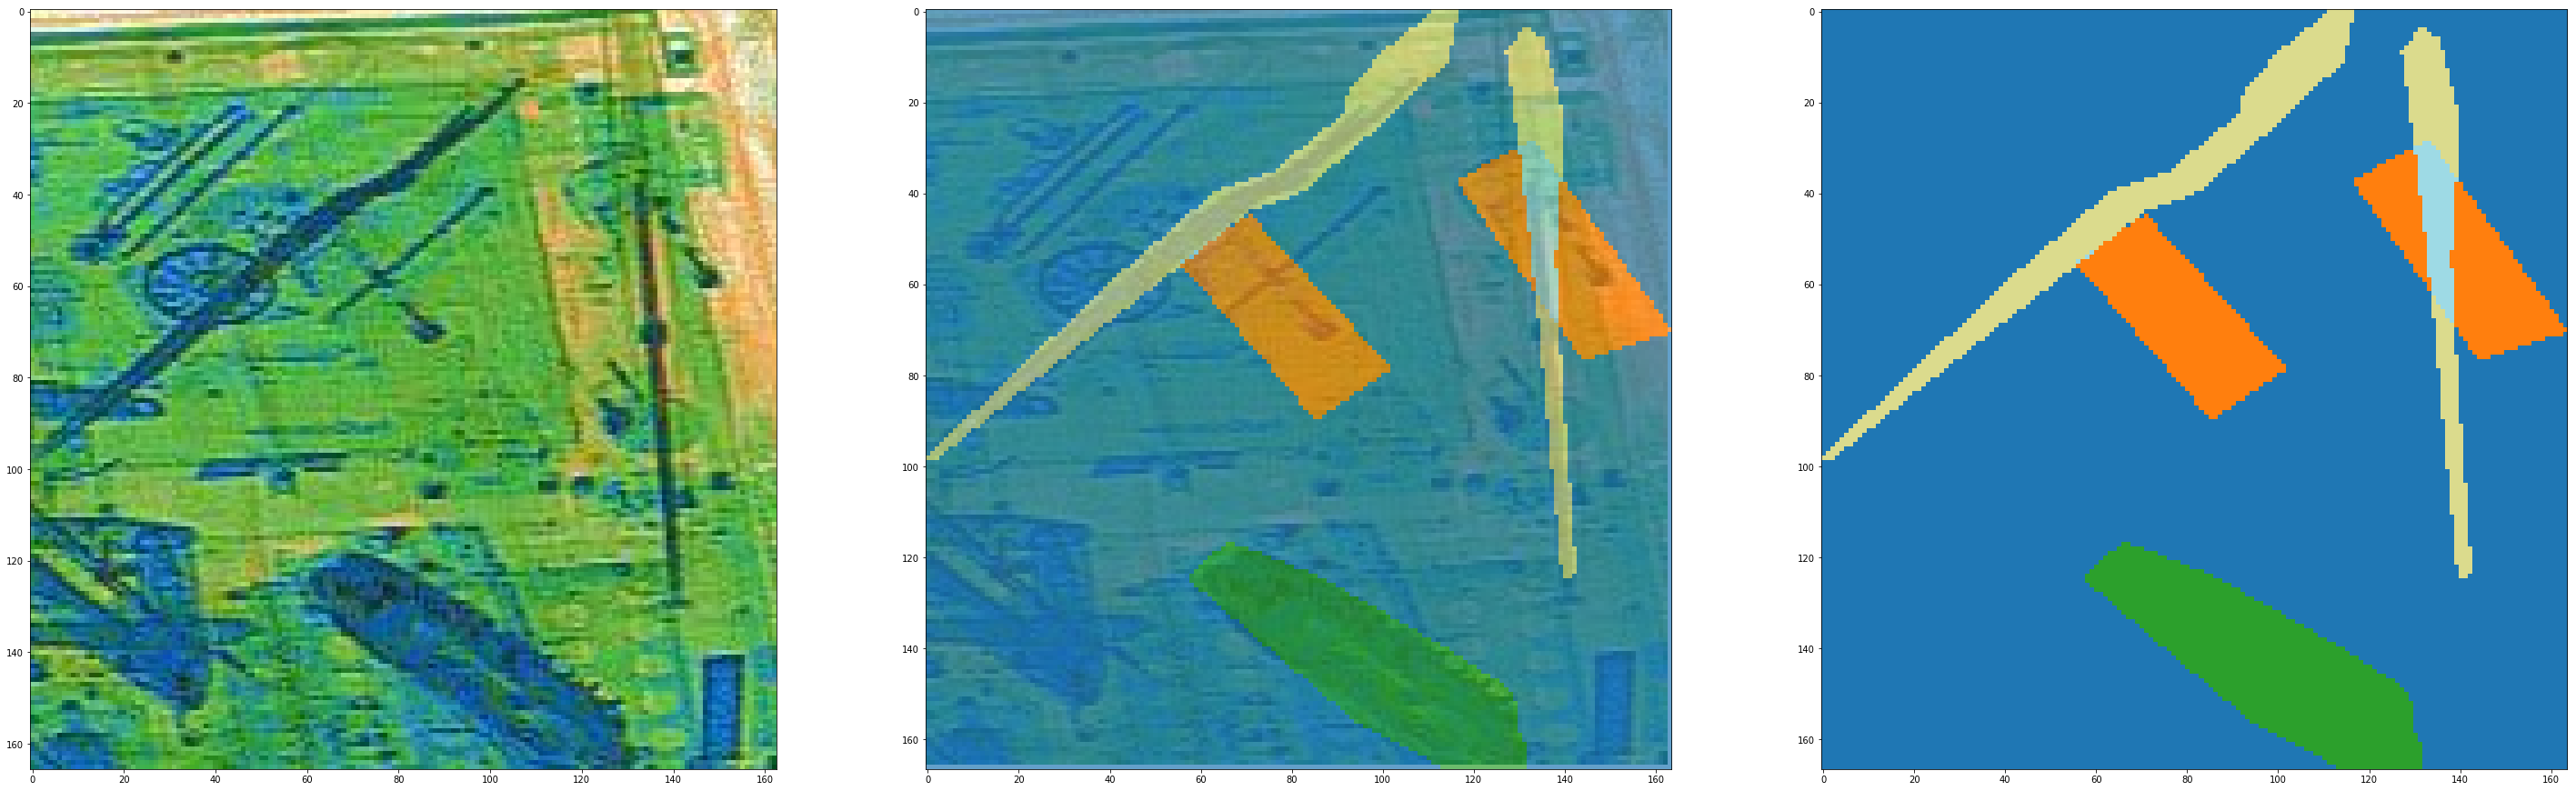

In [5]:
def zoom_show(sample):
    pixels = np.nonzero(sample['masks'])
    y_min, y_max = np.min(pixels[0]), np.max(pixels[0])
    x_min, x_max = np.min(pixels[1]), np.max(pixels[1])
    image = sample['image'].crop((x_min, y_min, x_max, y_max))
    masks = sample['masks'][y_min:y_max+1, x_min:x_max+1]
    show_sample_and_mask(dict(image=image, masks=masks))
sample = dataset[1]
zoom_show(sample)

## Statstics

In [139]:
n_pixels = [[], [], [], [], [], []]

for i, s in enumerate(dataset):
    #if i >= 100:
    #    break
    masks = s['masks']
    total_pixels = masks.shape[0] * masks.shape[1]
    for l, n in enumerate(n_pixels):
        if l == 0:
            n.append(total_pixels - np.count_nonzero(masks))
        else:
            m = masks & (2 ** l)
            c = np.count_nonzero(m)
            n.append(c)

n_pixels = np.asarray(n_pixels)

In [140]:
total_n_pixels = np.sum(n_pixels, axis=1)
print(dataset.classnames)
print('No.  ', total_n_pixels)

pos_pixels = [n_pix[n_pix > 0] for n_pix in n_pixels]

min_pixels = [np.min(n_pix).astype(n_pix.dtype) for n_pix in pos_pixels]
mean = [np.mean(n_pix).astype(n_pix.dtype) for n_pix in pos_pixels]
std = [np.std(n_pix).astype(n_pix.dtype) for n_pix in pos_pixels]
median = [np.median(n_pix).astype(n_pix.dtype) for n_pix in pos_pixels]
max_pixels = [np.max(n_pix).astype(n_pix.dtype) for n_pix in pos_pixels]
print('min. ', min_pixels)
print('mean.', mean)
print('std. ', std)
print('med. ', median)
print('max. ', max_pixels)

['background', '铁壳打火机', '黑钉打火机', '刀具', '电源和电池', '剪刀']
No.   [750875019   3052990   4511874   3783715   7681810   4649290]
min.  [61212, 114, 560, 487, 180, 256]
mean. [371536, 4348, 4032, 3058, 5345, 4540]
std.  [175934, 3095, 2311, 1602, 4234, 2706]
med.  [318524, 3407, 3433, 2665, 4633, 4134]
max.  [1097655, 15779, 18138, 12068, 24926, 15495]


In [141]:
per_pixels = [n_pix[n_pix > 0] / n_pixels[0, n_pix > 0] for n_pix in n_pixels]

print(dataset.classnames)
print('%.   ', total_n_pixels / total_n_pixels[0])

per_min_pixels = [np.min(n_pix) for n_pix in per_pixels]
per_mean = [np.mean(n_pix) for n_pix in per_pixels]
per_std = [np.std(n_pix) for n_pix in per_pixels]
per_median = [np.median(n_pix) for n_pix in per_pixels]
per_max_pixels = [np.max(n_pix) for n_pix in per_pixels]
print('min. ', per_min_pixels)
print('mean.', per_mean)
print('std. ', per_std)
print('med. ', per_median)
print('max. ', per_max_pixels)

['background', '铁壳打火机', '黑钉打火机', '刀具', '电源和电池', '剪刀']
%.    [1.         0.00406591 0.00600882 0.00503907 0.01023048 0.00619183]
min.  [1.0, 0.000491644469889202, 0.0009353052686079819, 0.0009731066548628038, 0.0005925936016919569, 0.0005461707581563813]
mean. [1.0, 0.012534401545370562, 0.011501178927104373, 0.009229438478927708, 0.01664627975620748, 0.013351460370243973]
std.  [0.0, 0.01026290302348333, 0.008379984243559763, 0.006811142226806252, 0.017017546857980077, 0.010255862242607881]
med.  [1.0, 0.008734175315611197, 0.009404897699129595, 0.007649421395380533, 0.011693873069321426, 0.010864672361512777]
max.  [1.0, 0.0507608532053088, 0.07901378181746485, 0.06703608719545705, 0.16869834320866514, 0.07411107579129013]


## Data splits

In [142]:
mask_pixels = np.sum(n_pixels[1:], axis=0)
min_mask_pixels = np.min(mask_pixels)
mask_pixels_per = (mask_pixels - min_mask_pixels) / (np.max(mask_pixels) - min_mask_pixels)
groups = (mask_pixels_per * 5+1).astype(int) # group by size of all masks

In [143]:
def plot_splits_hist(y, split, ax):
    train_index, test_index = split
    y_train = [y[i] for i in train_index]
    y_test = [y[i] for i in test_index]
    ax.hist([y_train, y_test], density=True)
    plt.tight_layout()

def plot_cv_y_hist(cv, X, y, groups, ax):
    splits = cv.split(X, y, groups)
    plot_splits_hist(y, next(splits), ax)

def plot_cv_groups_hist(cv, X, y, groups, ax):
    splits = cv.split(X, y, groups)
    plot_splits_hist(groups, next(splits), ax)

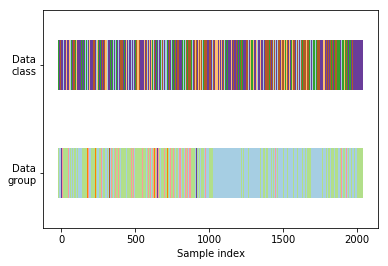

In [144]:
X = dataset
y = np.argmax(n_pixels[1:], axis=0) # group by biggest of object in image

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")

visualize_groups(y, groups)

In [145]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    """
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'group']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

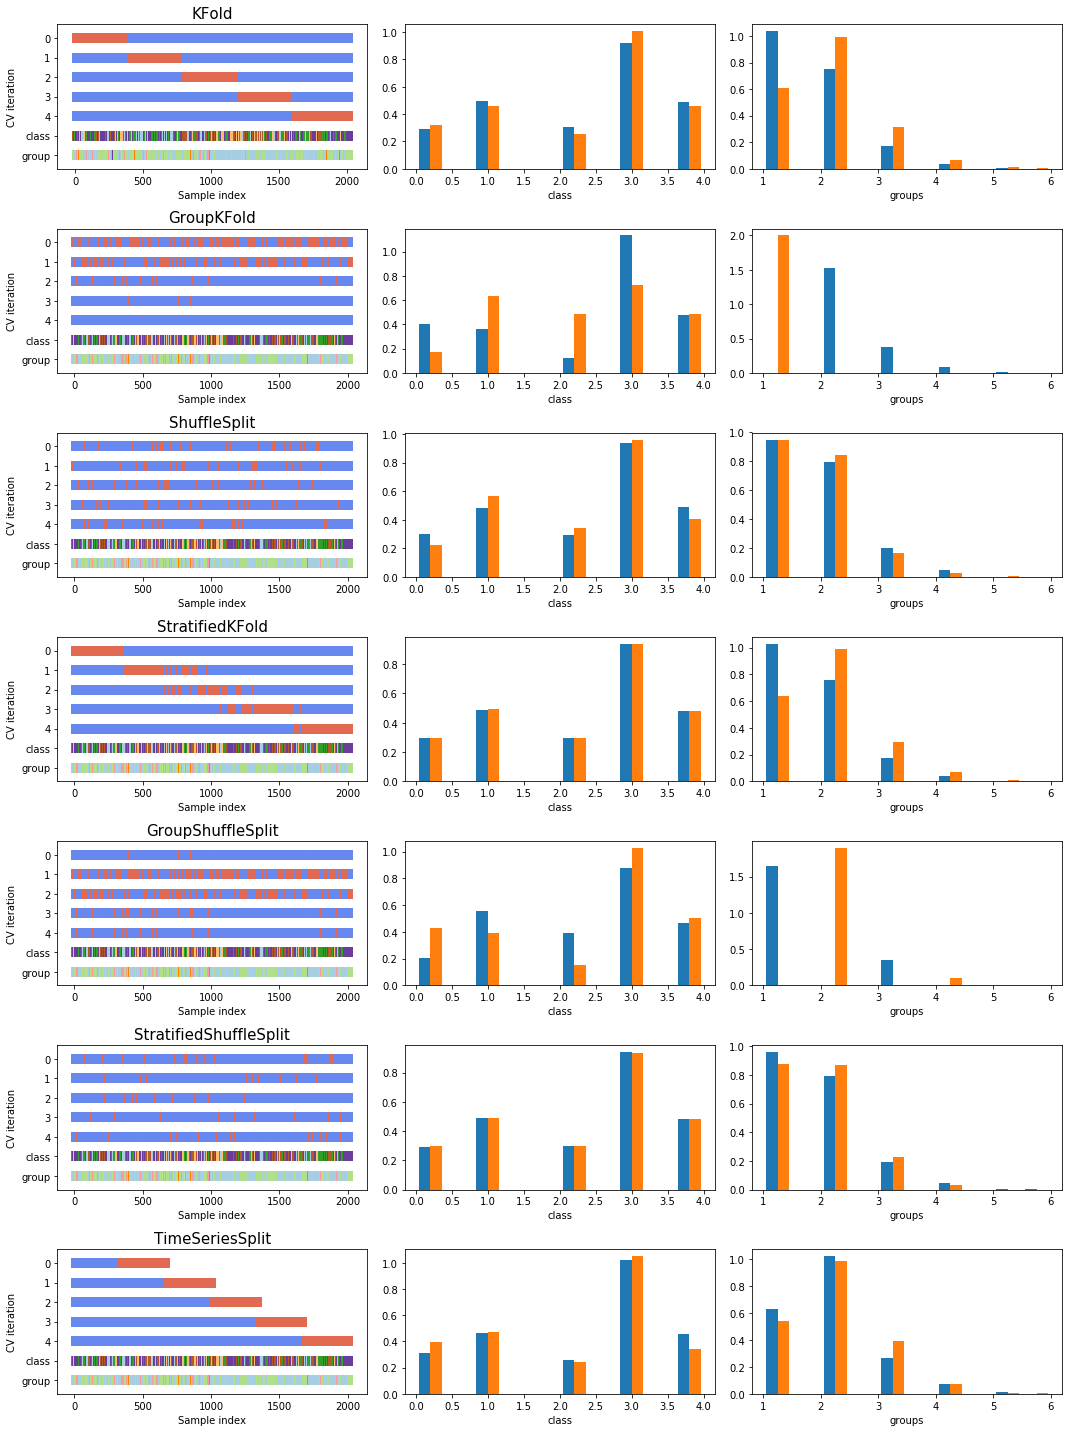

In [146]:
from sklearn.model_selection import KFold, GroupKFold, ShuffleSplit, StratifiedKFold, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit
cvs = [KFold, GroupKFold, ShuffleSplit, StratifiedKFold,
       GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit]
n_splits = 5
fig = plt.figure(figsize=(15, 20))
for i, cv in enumerate(cvs):
    this_cv = cv(n_splits=n_splits)
    ax = plt.subplot(len(cvs), 3, i * 3 +1)
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)
    #ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
    #          ['Testing set', 'Training set'], loc=(1.02, .8))
    # Make the legend fit
    plt.tight_layout()
    #fig.subplots_adjust(right=.7)
    ax = plt.subplot(len(cvs), 3, i * 3 +2)
    plot_cv_y_hist(this_cv, X, y, groups, ax)
    ax.set_xlabel('class')
    
    ax = plt.subplot(len(cvs), 3, i * 3 +3)
    plot_cv_groups_hist(this_cv, X, y, groups, ax)
    ax.set_xlabel('groups')
plt.show()


## StratifiedShuffleSplit

In [147]:
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=1/n_splits, random_state=2018)
splits = cv.split(X, y, groups)
group_k_fold = []
images_ids = dataset.ids
splits = list(splits)
test_groups = []
for train_index, test_index in splits:
    train_image_ids = [images_ids[i] for i in train_index]
    test_image_ids = [images_ids[i] for i in test_index]
    group_k_fold.append(dict(train=train_image_ids, valid=test_image_ids))
    test_group = np.unique([groups[i] for i in test_index])
    test_groups.append(test_group)

### add normal images to test dataset

In [148]:
normal_images = os.listdir('/media/data/jinnan2/jinnan2_round2_train_20190401/normal/')

In [149]:
for i, (g, fold) in enumerate(zip(test_groups, group_k_fold)):
    print(i, g, len(fold['valid']))
    np.random.seed(i)
    np.random.shuffle(normal_images)
    group_k_fold[i]['test'] = normal_images[:len(fold['valid'])] + fold['valid']  # same number of empty and non-empty

0 [1 2 3 4 5 6] 405
1 [1 2 3 4] 405
2 [1 2 3 4 5] 405
3 [1 2 3 4 5] 405
4 [1 2 3 4 5] 405


In [150]:
for i, fold in enumerate(group_k_fold):
    print(i, len(fold['train']), len(fold['valid']), len(fold['test']))

0 1616 405 810
1 1616 405 810
2 1616 405 810
3 1616 405 810
4 1616 405 810


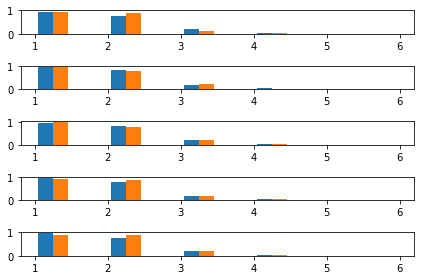

In [151]:
for i, s in enumerate(splits):
    ax = plt.subplot(len(splits), 1, i + 1)
    plot_splits_hist(groups, s, ax)

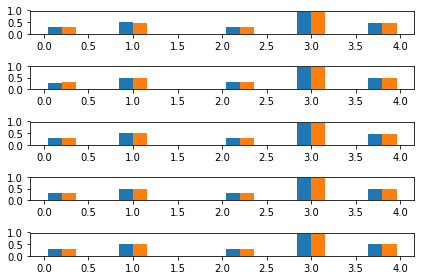

In [152]:
for i, s in enumerate(splits):
    ax = plt.subplot(len(splits), 1, i + 1)
    plot_splits_hist(y, s, ax)

In [153]:
import json
json.dump(group_k_fold, open('/media/data/jinnan2/jinnan2_round2_train_20190401/5_fold.json', 'w'))

# Data augmentation

In [5]:
import random
from train import train_transform, Compose
from trainer.data import TransformedDataset
from trainer.transforms.vision import *

transform = Compose([train_transform(), ToPILImage()])

dataset_t = TransformedDataset(dataset, transform)
print(dataset_t)

TransformedDataset
    XRayDataset
        description: XRAY Instance Dataset 
        url: 
        version: 0.2.0
        year: 2019
        contributor: qianxiao
        date_created: 2019-03-28 02:23:06.112949
        Number of datapoints: 2021
        Number of classes: 6
        Root Location: /media/data/jinnan2/jinnan2_round2_train_20190401
    Transforms: Compose(Compose(FilterSample(['image', 'masks']),
                                RandomOrder(RandomApply(p=0.5,
                                                        RandomPad(max_padding=(85, 85), fill=(255, 255, 255))),
                                            RandomApply(p=0.5,
                                                        TryApply(transform=RandomCrop(min_size=(170, 170), max_size=(384, 384), max_aspect_ratio=2, truncate_bbox=True, remove_bbox_outside=False), max_trail=1))),
                                Resize(size=(256, 256), interpolation=BILINEAR),
                                RandomOrder(RandomAp

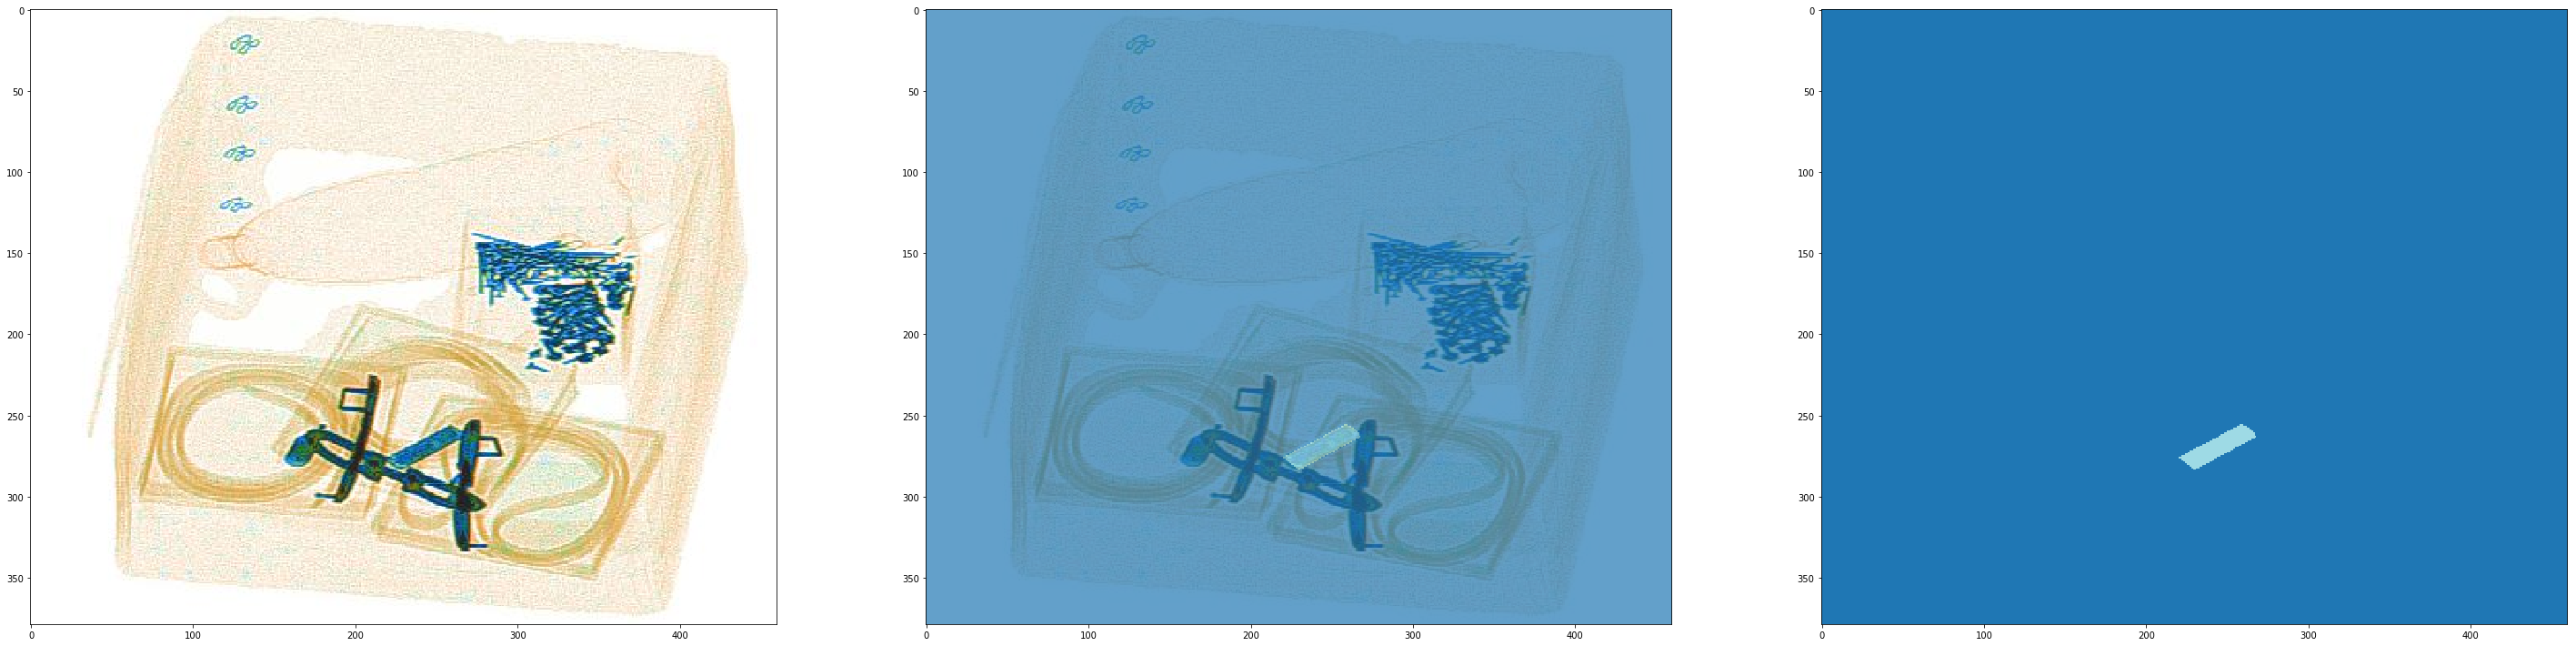

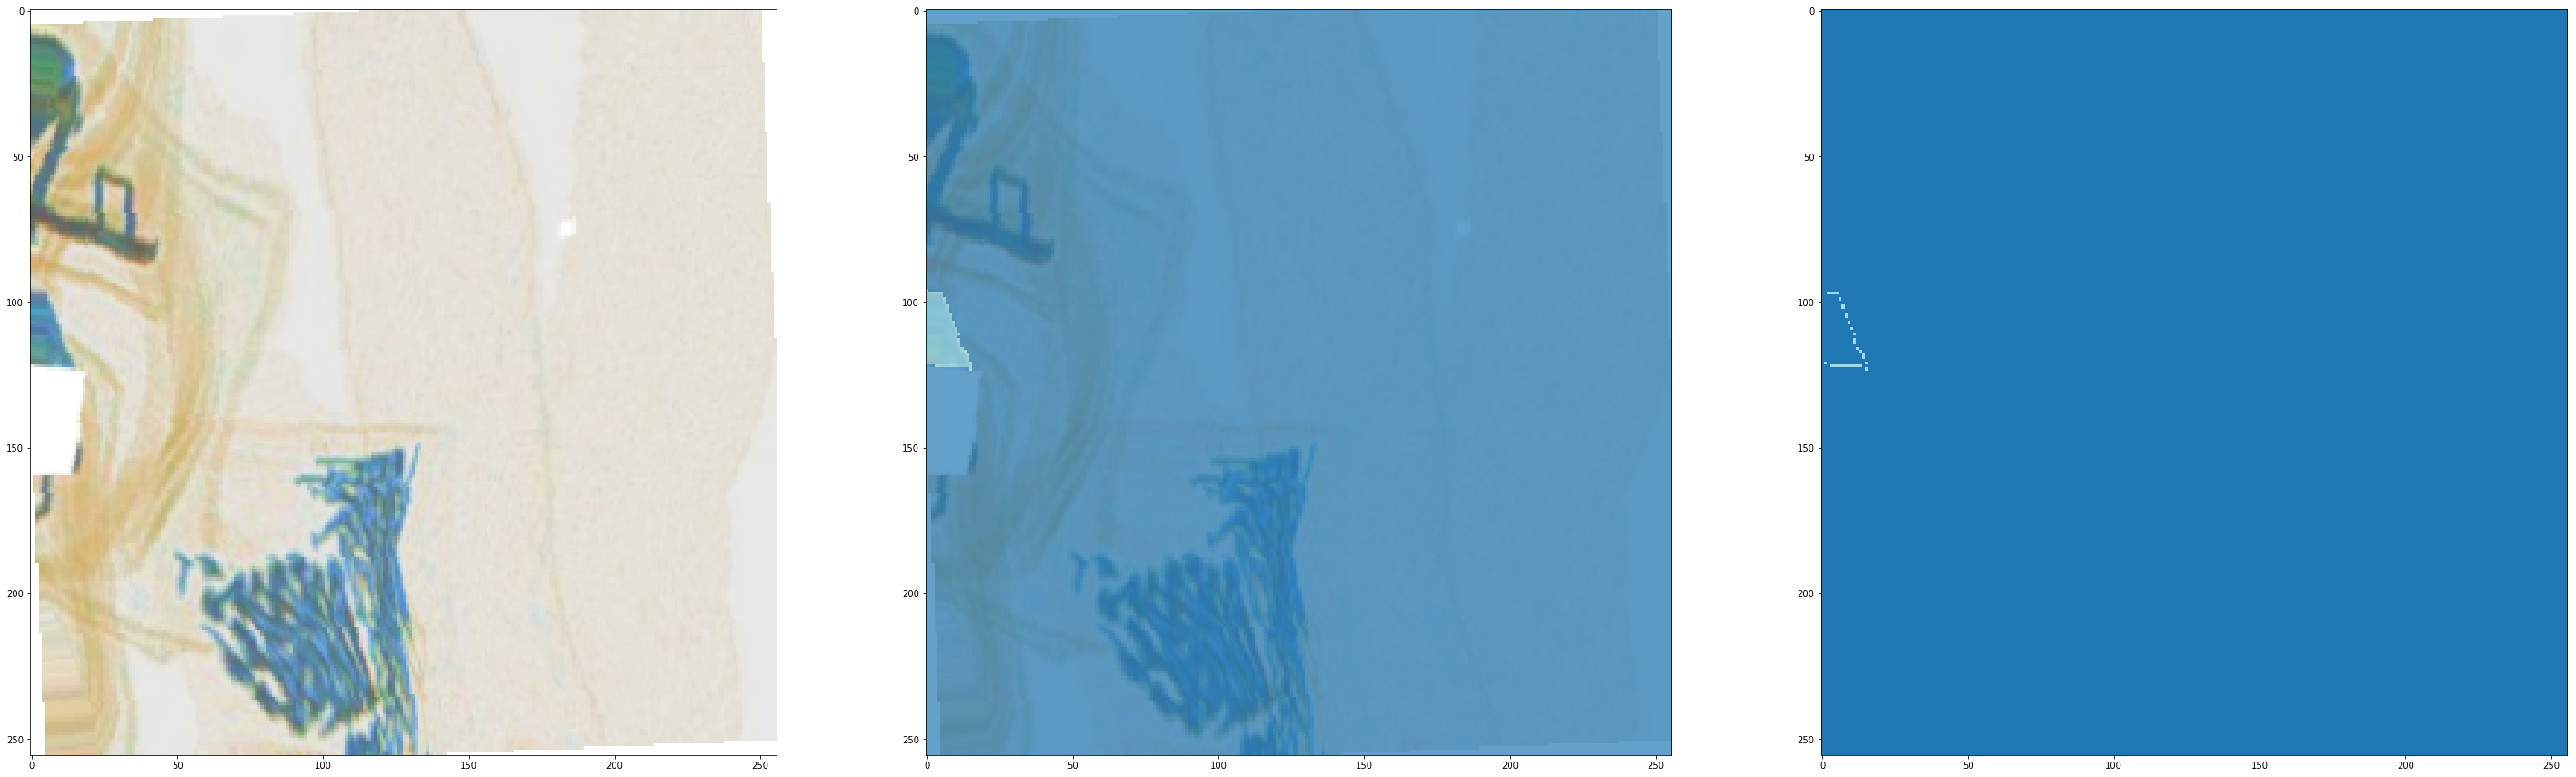

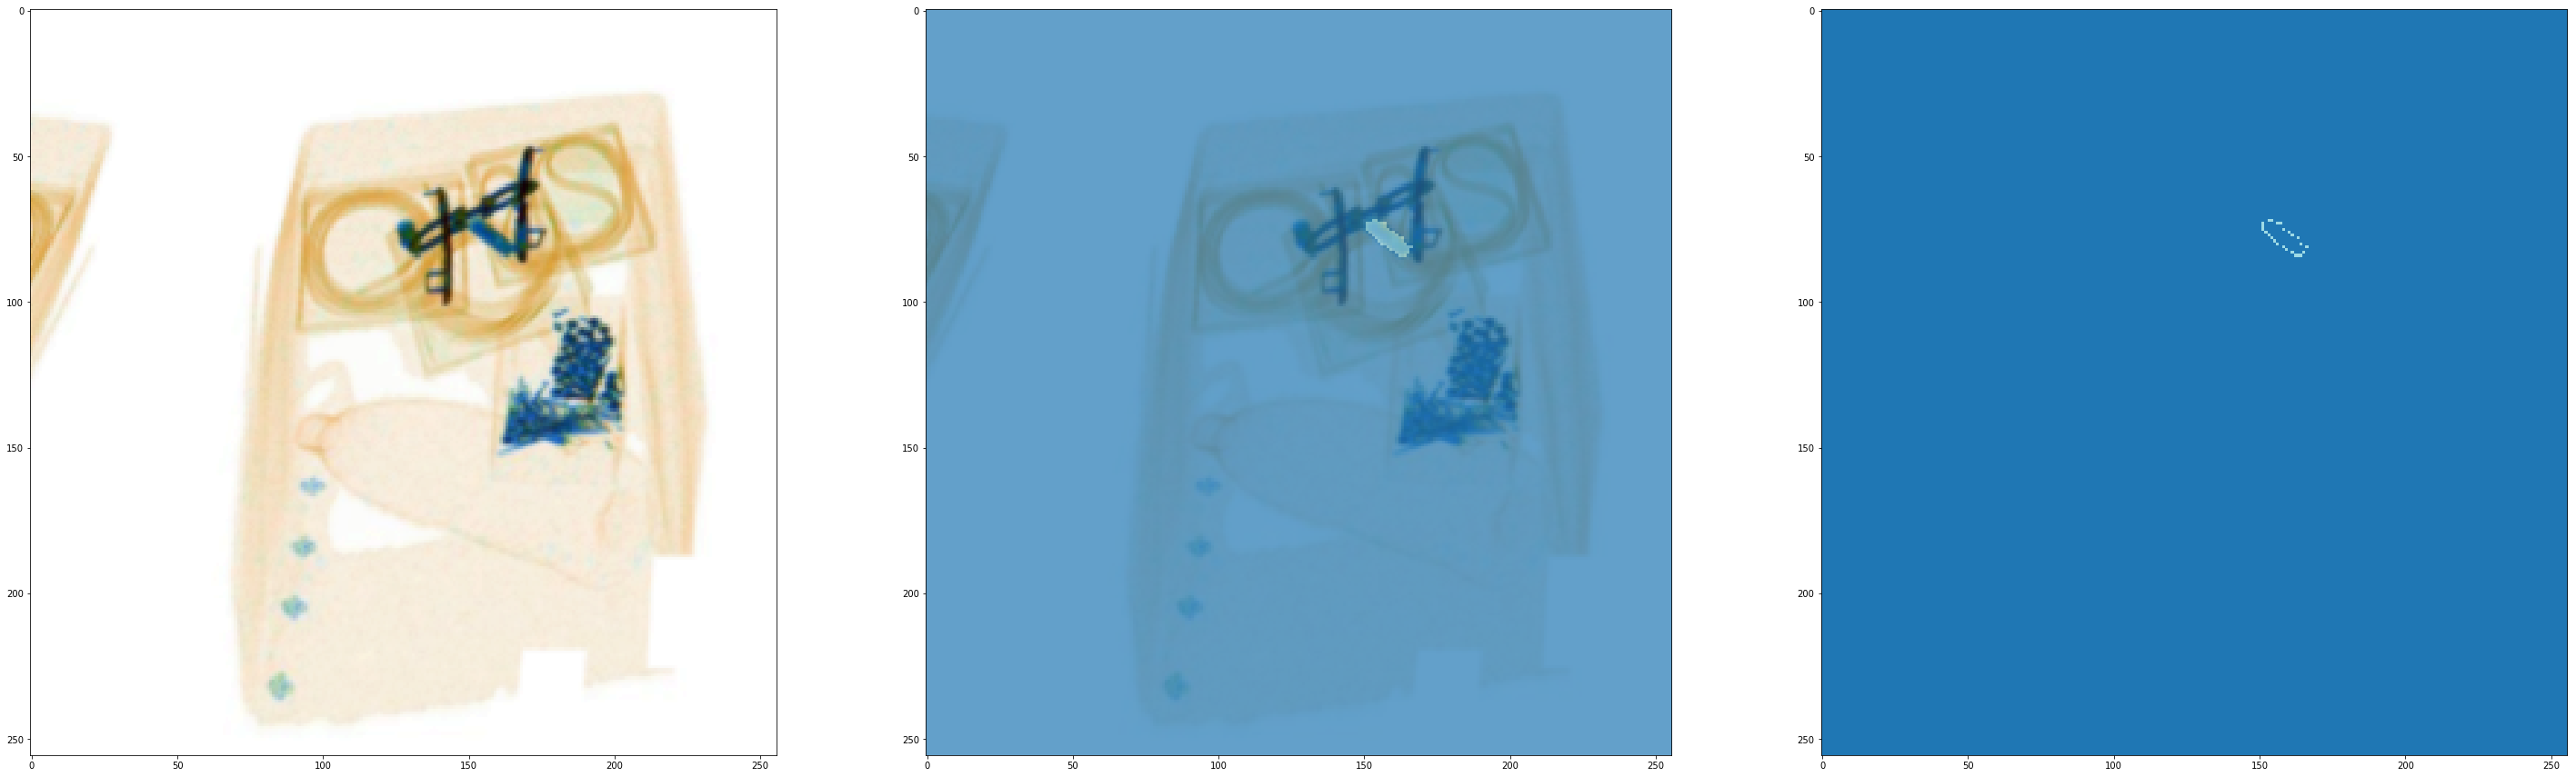

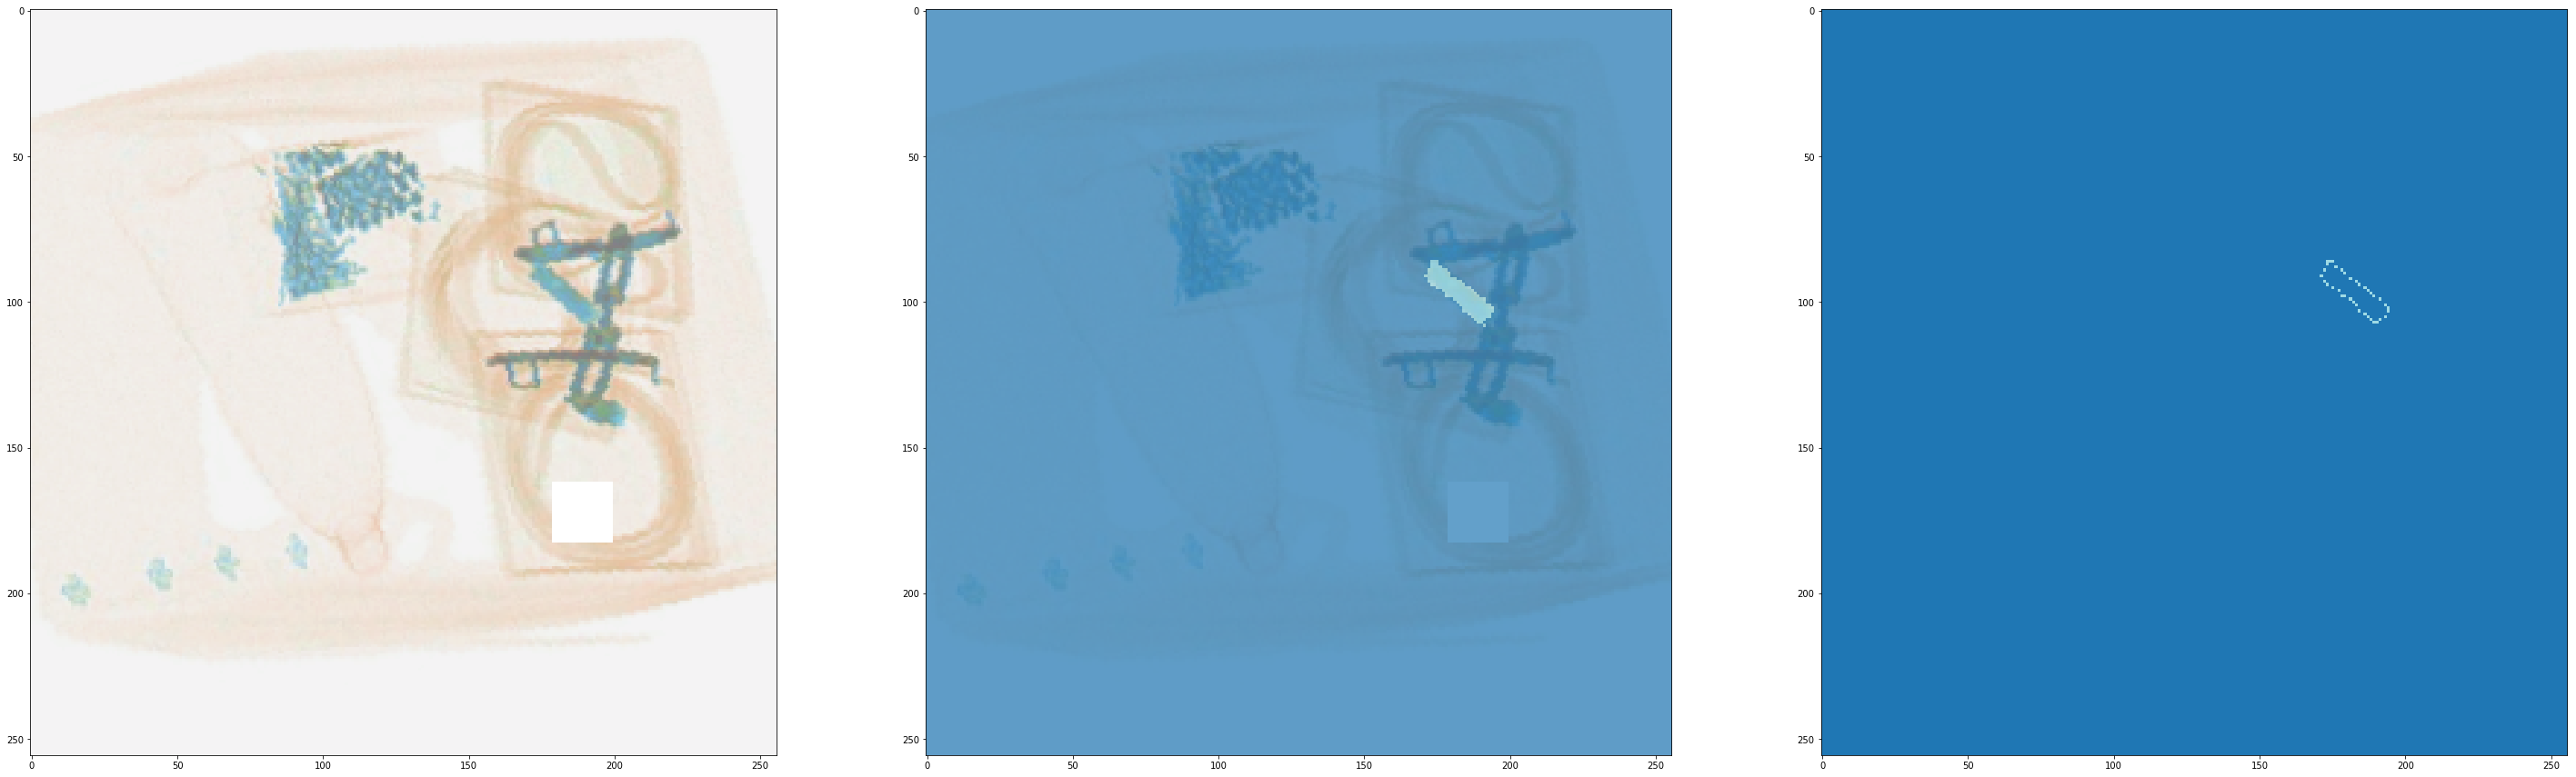

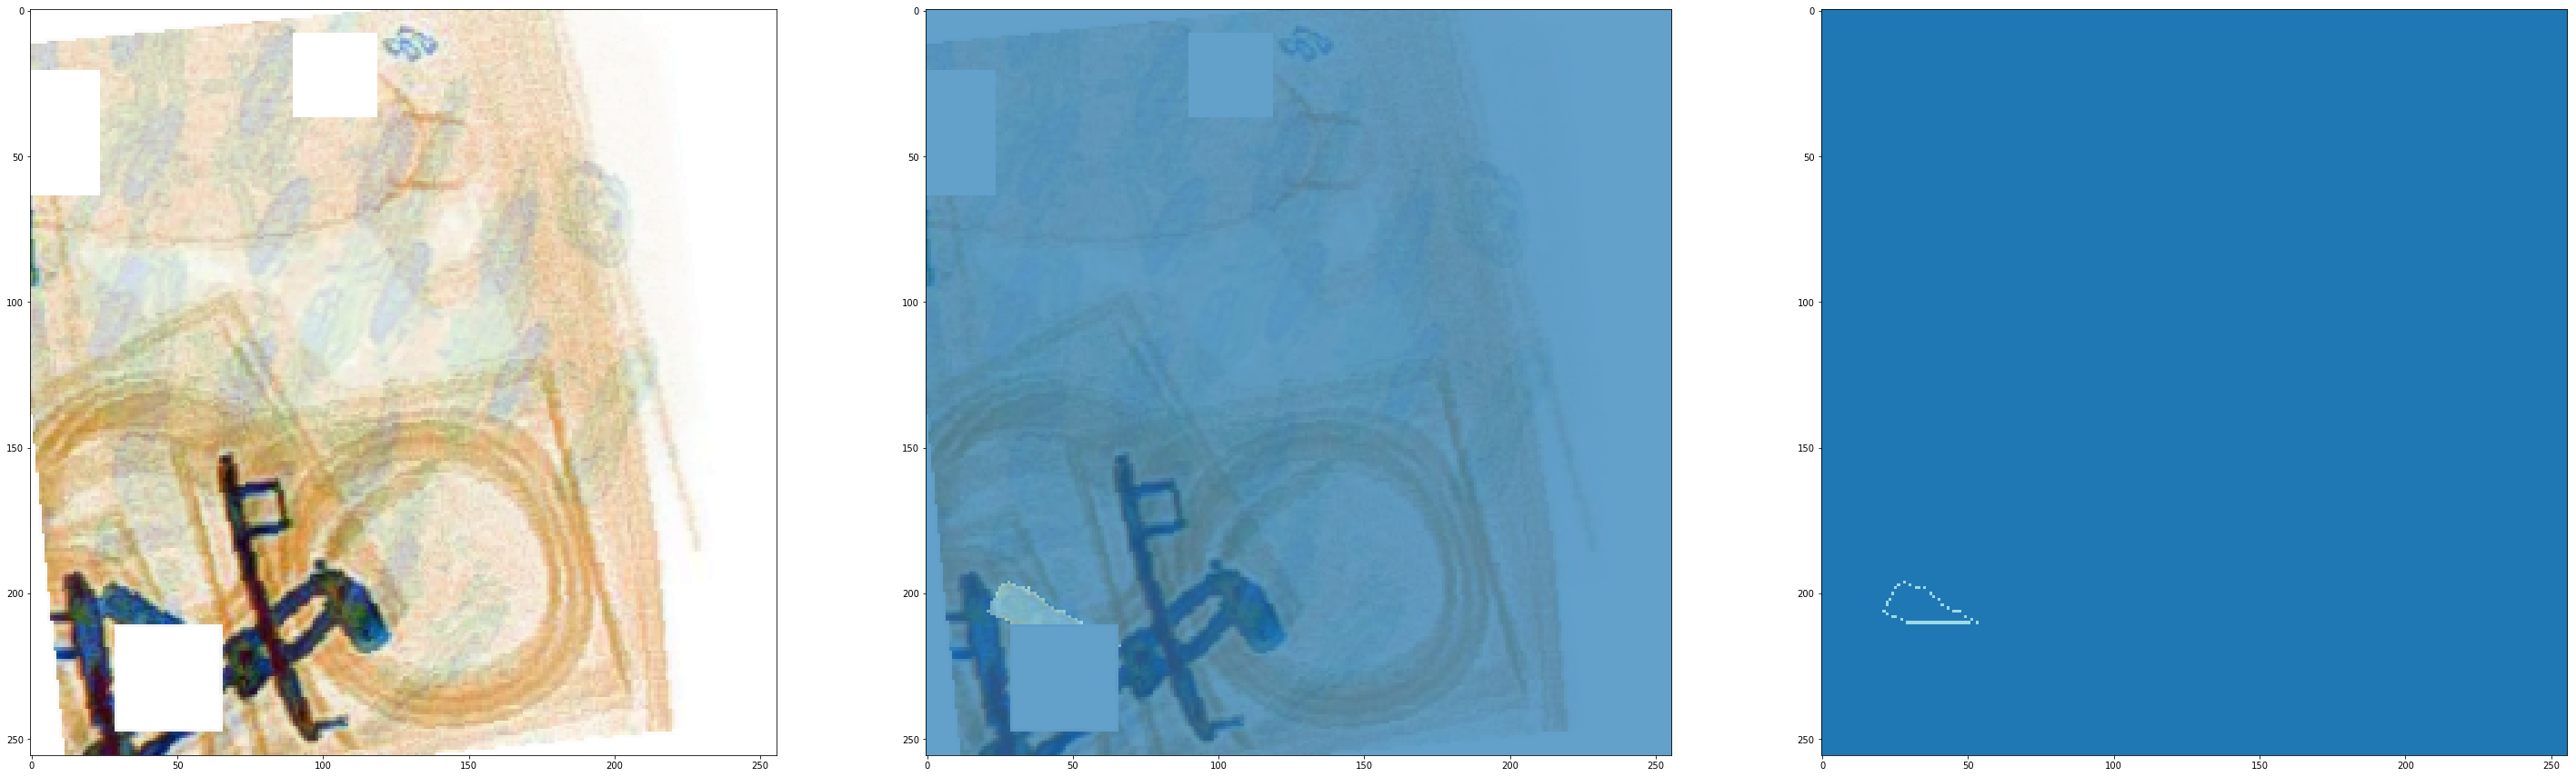

In [13]:
sample_id = random.choice(range(len(dataset)))
#sample_id = 0
show_sample_and_mask(dataset[sample_id])
for i in range(4):
    sample = dataset_t[sample_id]
    show_sample_and_mask(sample)

In [88]:
from skimage import feature
from data.coco import mask_to_class_segments, mask_to_instances, mask_to_instance_edges
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(40)

def show_masks(m):
    plt.figure(figsize=(50, 20))
    for i, mi in enumerate(m):
        plt.subplot(1, len(m), i + 1)
        plt.imshow(mi)
        plt.title(dataset.classnames[i + 1], fontproperties=fontP)

1653


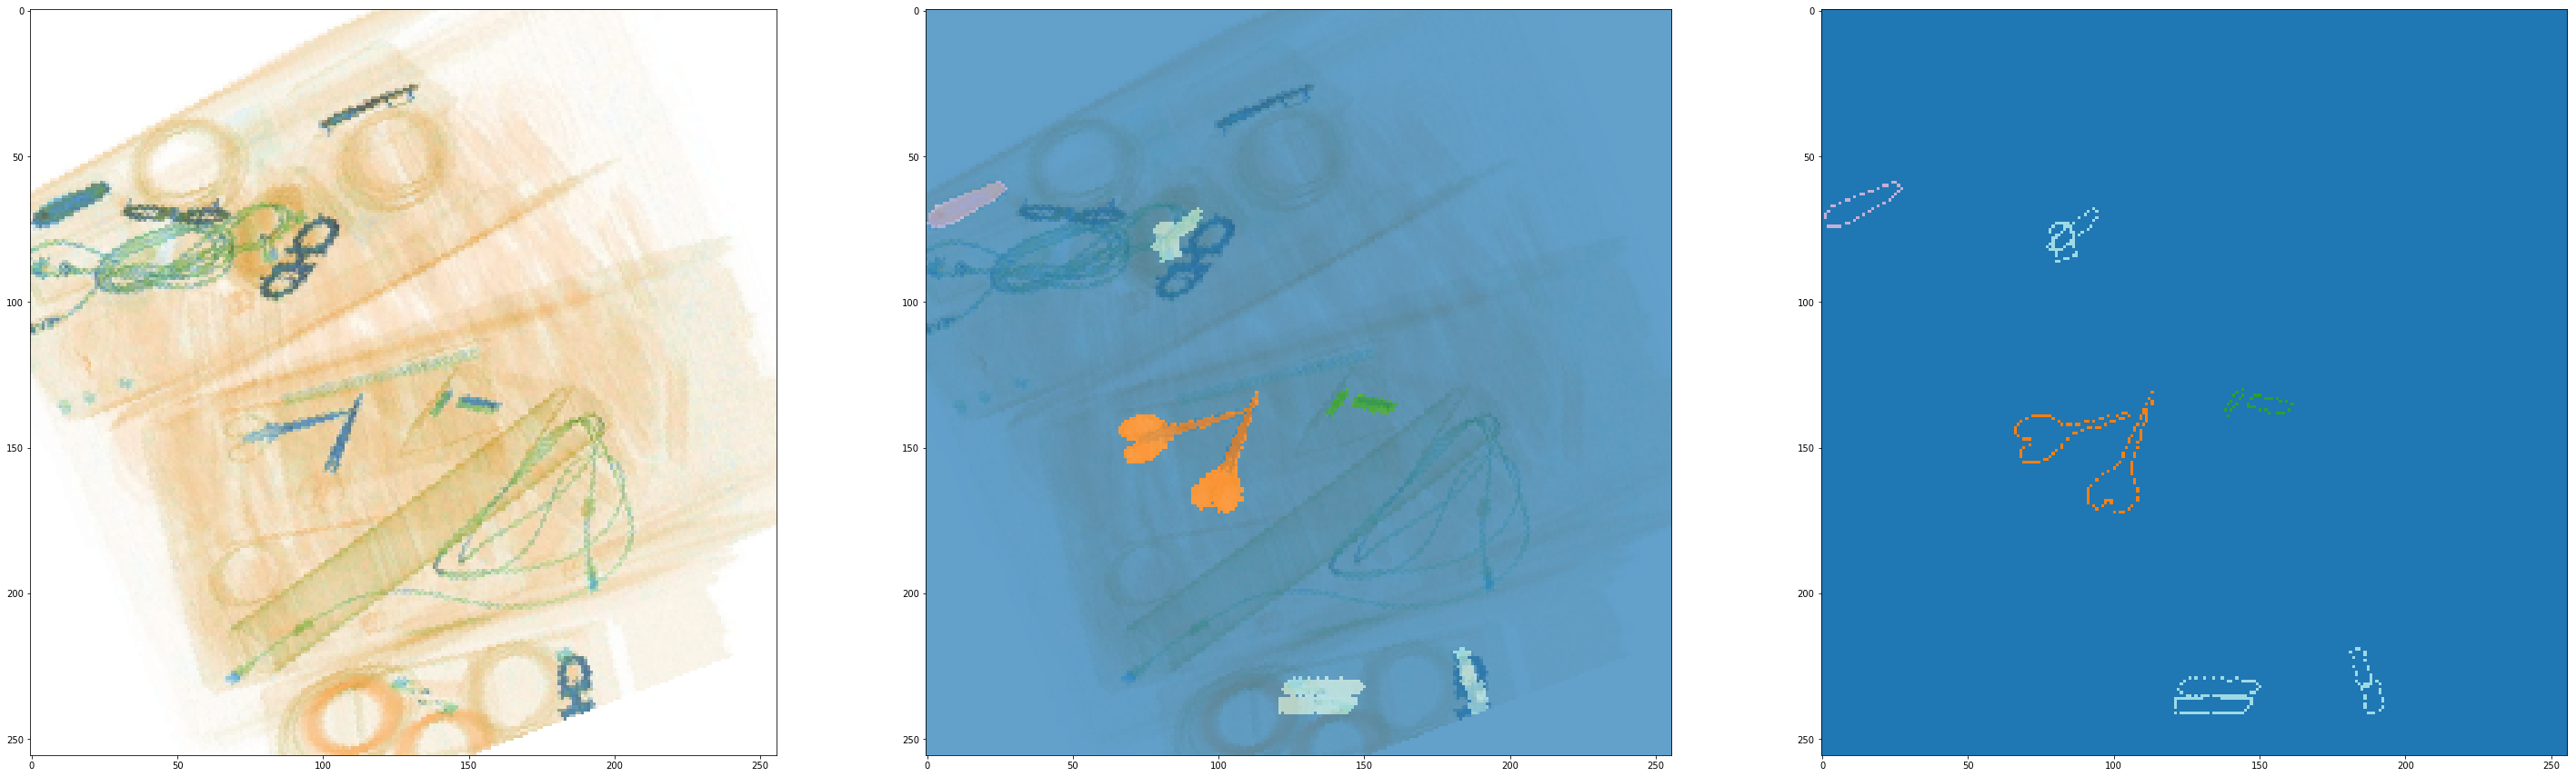

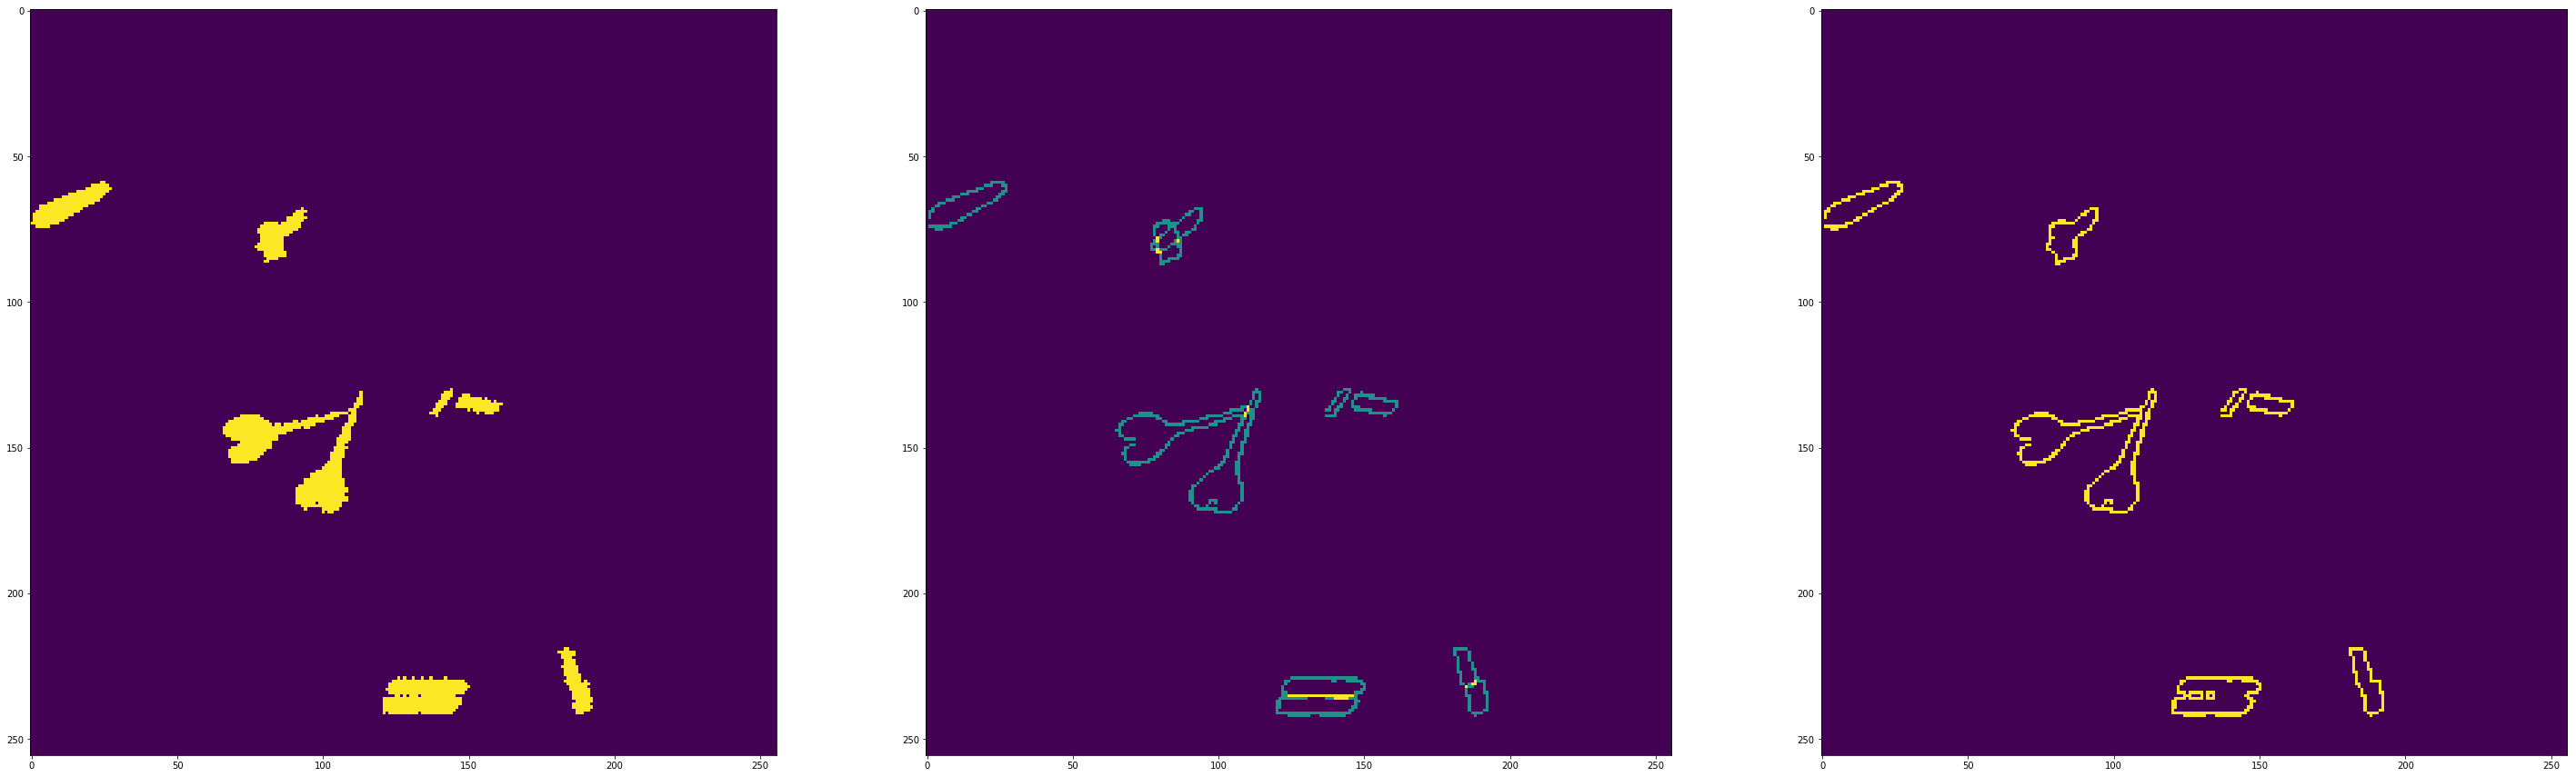

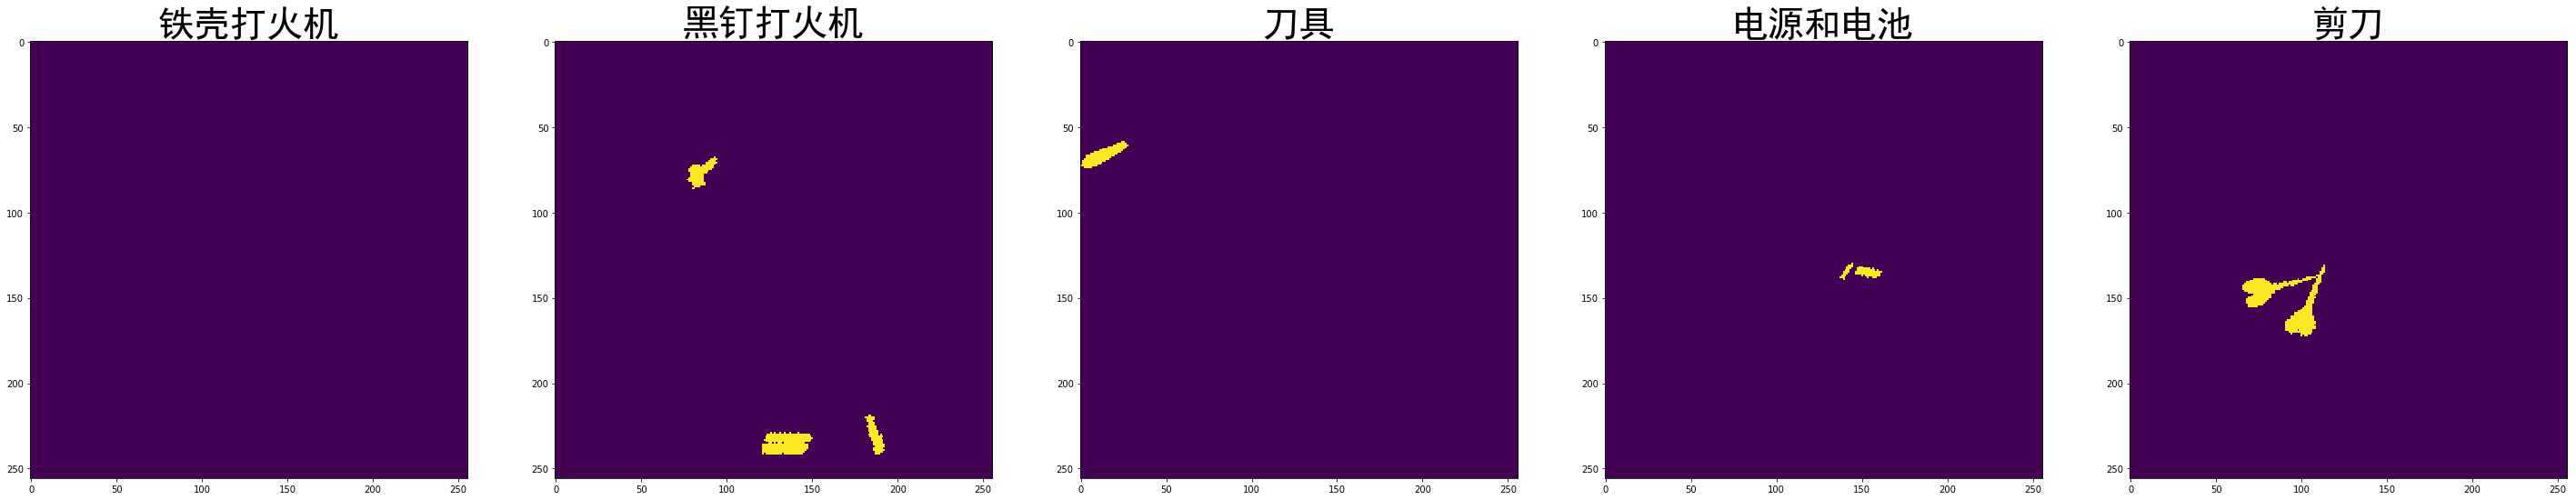

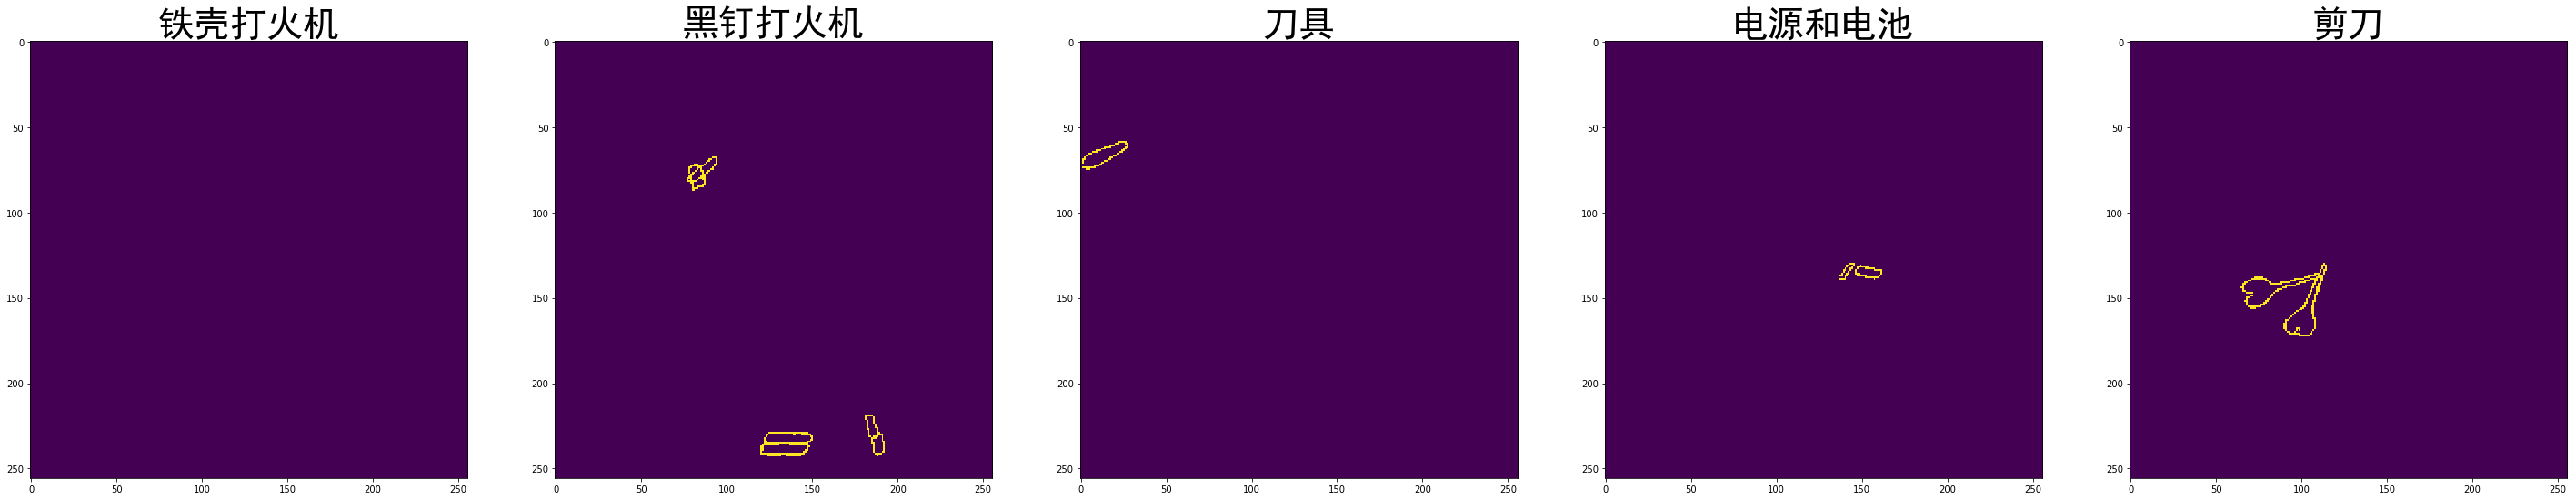

In [123]:
#sample_id = random.choice(range(len(dataset)))
sample_id = 1653
#sample = dataset_t[sample_id]

print(sample_id)
show_sample_and_mask(sample)
masks = sample['masks']
        
edges = sum(mask_to_instance_edges(masks))
instances = masks > 0

plt.figure(figsize=(50, 20))
plt.subplot(1, 3, 1)
plt.imshow(instances)
plt.subplot(1, 3, 2)
plt.imshow(edges)
plt.subplot(1, 3, 3)
plt.imshow(feature.canny(instances, sigma=0) > 0)

seg = list(mask_to_class_segments(masks))
edges = list((sum(mask_to_instance_edges(s * masks)) > 0) if s.any() else np.zeros_like(masks) for s in seg)
show_masks(seg)
show_masks(edges)

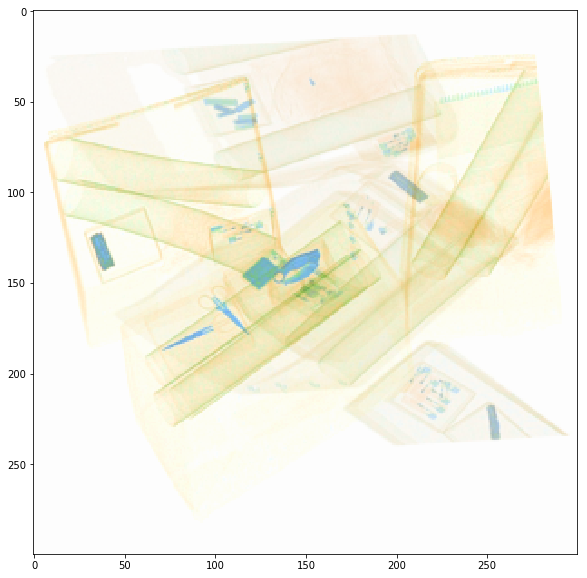

In [21]:
from PIL import Image
sample_a, sample_b = dataset[2], dataset[3]
alpha=1.5
weight = np.random.beta(alpha, alpha)
image_ab = Image.blend(sample_a['image'], sample_b['image'], weight)
plt.figure(figsize=(50, 10))
plt.imshow(image_ab)
plt.show()

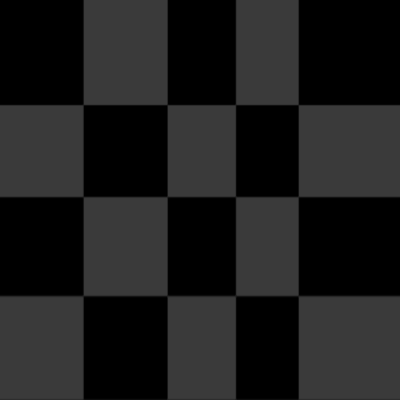

In [18]:
image = Image.open('/home/xu/Downloads/orig.png')
#image = image.convert('RGB')
#trans = Skew(0.4, direction=6)
trans = GridDistortion()
sample = trans(dict(image=image))
sample['image']

image